In [1]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("Phase2_Test")
    .getOrCreate()
)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/23 20:34:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql import functions as F;

jobs_path = "linkedin_job_postings.csv";
skills_path = "job_skills.csv";
summ_path = "job_summary.csv";

jobs_raw = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv(jobs_path)
);

skills_raw = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv(skills_path)
);

summ_raw = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv(summ_path)
);

def trim_cols(df):
    return df.toDF(*[c.strip() for c in df.columns]);

jobs = trim_cols(jobs_raw);
skills = trim_cols(skills_raw);
summ = trim_cols(summ_raw);

print("jobs_raw rows:", jobs.count());
print("skills_raw rows:", skills.count());
print("summ_raw rows:", summ.count());

jobs_raw rows: 1348488
skills_raw rows: 1296381


[Stage 12:============================================>           (31 + 8) / 39]

summ_raw rows: 48219735


In [3]:
jobs_sk = jobs.join(skills, on="job_link", how="left");

total_rows = jobs_sk.count();
missing_job_skills_count = jobs_sk.filter(F.col("job_skills").isNull()).count();
missing_job_link_count = jobs_sk.filter(F.col("job_link").isNull()).count();

pct_missing_job_link = (missing_job_link_count / total_rows) * 100;
pct_missing_job_skills = (missing_job_skills_count / total_rows) * 100;

rows_before = total_rows;

dup_count = (
    jobs_sk.select("job_link").count()
    - jobs_sk.select("job_link").dropDuplicates(["job_link"]).count()
);

jobs_sk = jobs_sk.dropDuplicates(["job_link"]);

rows_after = jobs_sk.count();

print("Total rows (before dedup):", rows_before);
print("pct_missing_job_link:", round(pct_missing_job_link, 4));
print("pct_missing_job_skills:", round(pct_missing_job_skills, 4));
print("Rows before cleaning:", rows_before);
print("Rows after cleaning:", rows_after);
print("Duplicates found and removed:", dup_count);

Total rows (before dedup): 1348488
pct_missing_job_link: 0.0
pct_missing_job_skills: 4.0129
Rows before cleaning: 1348488
Rows after cleaning: 1348463
Duplicates found and removed: 25


In [4]:
truthy = ["true", "t", "yes", "y", "1"];
falsy = ["false", "f", "no", "n", "0"];

bool_cols = ["got_summary", "got_ner", "is_being_worked"];

for col in bool_cols:
    s = F.lower(F.trim(F.col(col).cast("string")));
    jobs_sk = jobs_sk.withColumn(
        col,
        F.when(s.isin(truthy), F.lit(1))
         .when(s.isin(falsy), F.lit(0))
         .otherwise(F.lit(0))
    );

text_cols = ["job_link", "job_title", "company",
             "job_location", "job_level", "job_type"];

for col in text_cols:
    jobs_sk = jobs_sk.withColumn(
        col,
        F.when(F.col(col).isNull(), None).otherwise(
            F.regexp_replace(F.col(col).cast("string"), r"\s+", " ")
        )
    );
    jobs_sk = jobs_sk.withColumn(col, F.trim(F.col(col)));

print("type conversions and text cleanup.");

type conversions and text cleanup.


In [5]:
jobs_sk = jobs_sk.withColumn(
    "job_skills_clean",
    F.when(F.col("job_skills").isNull(), "")
     .otherwise(F.lower(F.col("job_skills").cast("string")))
);

jobs_sk = jobs_sk.withColumn(
    "job_skills_clean",
    F.regexp_replace("job_skills_clean", "[;|]", ",")
);

jobs_sk = jobs_sk.withColumn(
    "job_skills_clean",
    F.regexp_replace("job_skills_clean", r"\s*,\s*", ",")
);

jobs_sk = jobs_sk.withColumn(
    "job_skills_clean",
    F.regexp_replace("job_skills_clean", r"\s+", " ")
);

jobs_sk = jobs_sk.withColumn("skills_arr_raw", F.split("job_skills_clean", ","));

jobs_sk = jobs_sk.withColumn(
    "skills_list",
    F.expr("filter(transform(skills_arr_raw, x -> trim(x)), x -> x <> '')")
);

jobs_sk = jobs_sk.drop("skills_arr_raw");

jobs_sk = jobs_sk.withColumn("skill_count", F.size("skills_list"));

clean_cols = [
    "job_link", "job_title", "company",
    "job_location", "job_level", "job_type",
    "job_skills_clean"
];

for col in clean_cols:
    jobs_sk = jobs_sk.withColumn(
        col,
        F.regexp_replace(F.col(col), r"\s+", " ")
    );
    jobs_sk = jobs_sk.withColumn(col, F.trim(F.col(col)));

print("job_skills cleaning and text normalization.");

job_skills cleaning and text normalization.


In [6]:
from pyspark.sql import functions as F;

final_rows = rows_after;
final_cols = len(jobs_sk.columns);

print("Total number of rows after cleaning:", final_rows);
print("Total number of columns after cleaning:", final_cols);
print("Percentage of missing values in job_link column:", round(pct_missing_job_link, 4));
print("Percentage of missing values in job_skills column:", round(pct_missing_job_skills, 4));

Total number of rows after cleaning: 1348463
Total number of columns after cleaning: 18
Percentage of missing values in job_link column: 0.0
Percentage of missing values in job_skills column: 4.0129


In [7]:
from pyspark.sql import functions as F;

rows_after = jobs_sk.count();
num_columns_after = len(jobs_sk.columns);

jobs_sk_export = jobs_sk.withColumn(
    "skills_list",
    F.concat_ws(";", F.col("skills_list"))
);

output_dir = "linkedin_jobs_skills_clean_pyspark";

(
    jobs_sk_export
    .coalesce(1)
    .write
    .mode("overwrite")
    .option("header", True)
    .csv(output_dir)
);

print("rows_after:", rows_after);
print("num_columns_after:", num_columns_after);


25/11/23 20:34:56 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 68:>                                                         (0 + 1) / 1]

rows_after: 1348463
num_columns_after: 18


**2.2 EDA**

Number of rows: 1348463
Number of columns: 18

Schema:
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: integer (nullable = false)
 |-- got_ner: integer (nullable = false)
 |-- is_being_worked: integer (nullable = false)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)
 |-- job_skills: string (nullable = true)
 |-- job_skills_clean: string (nullable = true)
 |-- skills_list: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- skill_count: integer (nullable = true)


Clean Sample Rows:


+--------------------------------------------------------+----------------------------+--------------------------------------------------+----------+--------+-----------+
|job_title                                               |company                     |job_location                                      |job_level |job_type|skill_count|
+--------------------------------------------------------+----------------------------+--------------------------------------------------+----------+--------+-----------+
|EVS Operator                                            |Sundus                      |Abu Dhabi, Abu Dhabi Emirate, United Arab Emirates|Mid senior|Onsite  |10         |
|Operations Supervisor                                   |Skydive Dubai               |Dubai, United Arab Emirates                       |Associate |Onsite  |11         |
|Production Assistant                                    |Sundus                      |United Arab Emirates                              |Associa

+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+----------+----------------+-----------+-----------+
|job_link|last_processed_time|got_summary|got_ner|is_being_worked|job_title|company|job_location|first_seen|search_city|search_country|search_position|job_level|job_type|job_skills|job_skills_clean|skills_list|skill_count|
+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+----------+----------------+-----------+-----------+
|0       |0                  |0          |0      |0              |0        |45     |53          |34        |43         |43            |43             |43       |44      |54089     |0               |0          |0          |
+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+

+-------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------+-----------+--------------+----------------+--------------------+---------+-------------------------------+---------------------------------+------------------+
|summary|            job_link| last_processed_time|        got_summary|            got_ner|     is_being_worked|           job_title|             company|        job_location|   first_seen|search_city|search_country| search_position|           job_level| job_type|                     job_skills|                 job_skills_clean|       skill_count|
+-------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------+-----------+--------------+----------------+--------------------+---------+-------------------------------+----

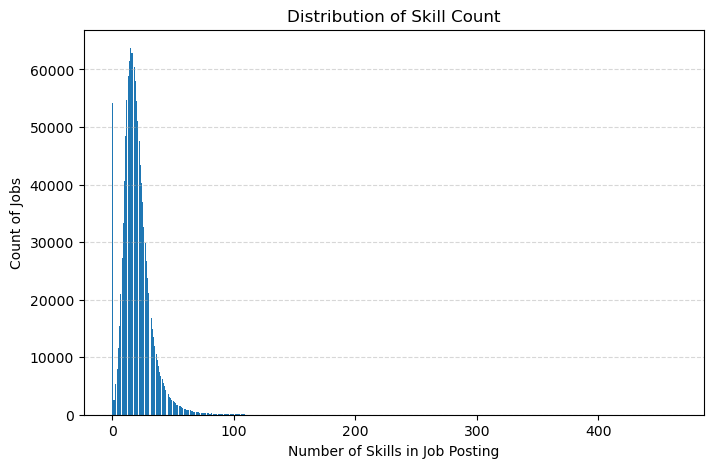


Top 10 Job Titles:


+-------------------------------+-----+
|job_title                      |count|
+-------------------------------+-----+
|LEAD SALES ASSOCIATE-FT        |7325 |
|Shift Manager                  |5818 |
|First Year Tax Professional    |5356 |
|Assistant Manager              |5346 |
|Customer Service Representative|5203 |
|LEAD SALES ASSOCIATE-PT        |4924 |
|Store Manager                  |4792 |
|CUSTOMER SERVICE REPRESENTATIVE|4218 |
|Registered Nurse               |4190 |
|Hourly Supervisor & Training   |2955 |
+-------------------------------+-----+



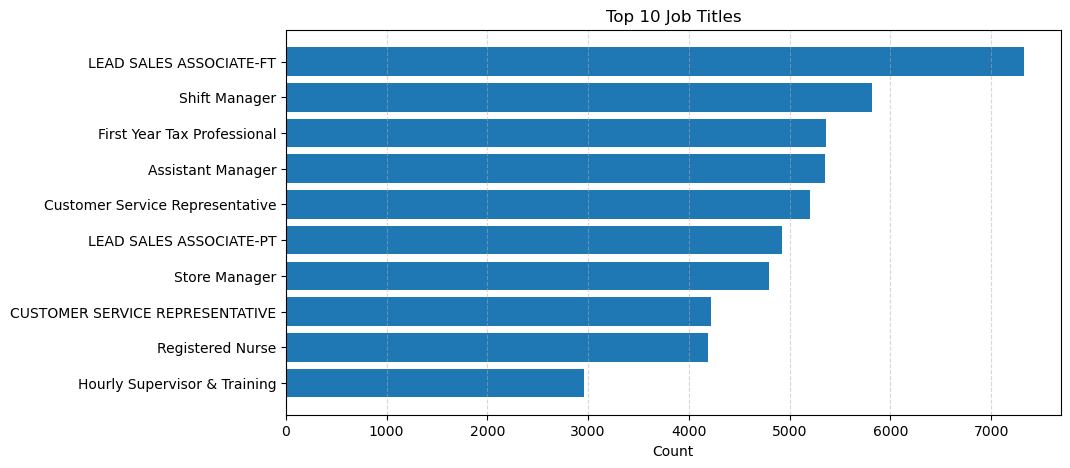


Top 10 Companies:


+----------------------+-----+
|company               |count|
+----------------------+-----+
|Health eCareers       |41597|
|Jobs for Humanity     |27680|
|TravelNurseSource     |16142|
|Dollar General        |14815|
|PracticeLink          |9737 |
|Energy Jobline        |9364 |
|Gotham Enterprises Ltd|8935 |
|Jobot                 |8713 |
|ClearanceJobs         |8599 |
|McDonald's            |8125 |
+----------------------+-----+



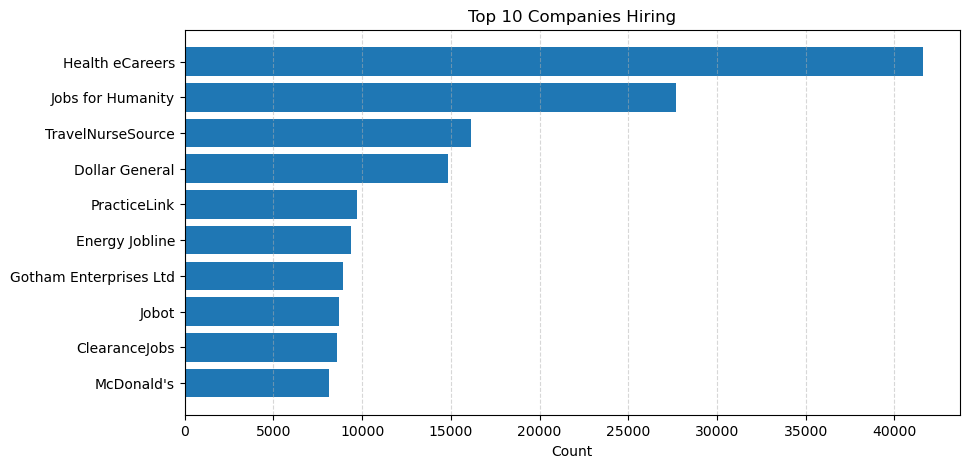


Top 20 Skills:


+----------------------+------+
|skill                 |count |
+----------------------+------+
|communication         |370052|
|customer service      |278035|
|teamwork              |227549|
|communication skills  |195841|
|leadership            |185138|
|problem solving       |148997|
|time management       |142874|
|attention to detail   |133932|
|problemsolving        |129300|
|project management    |121527|
|interpersonal skills  |100225|
|patient care          |99915 |
|sales                 |92983 |
|nursing               |87949 |
|collaboration         |87086 |
|training              |83639 |
|data analysis         |81949 |
|microsoft office suite|75511 |
|organizational skills |75259 |
|inventory management  |71902 |
+----------------------+------+



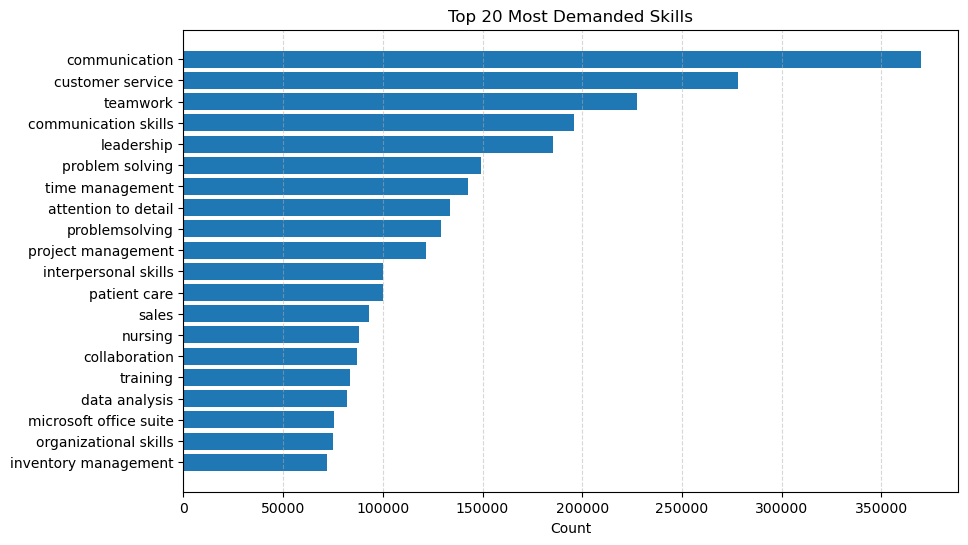


Top 10 Job Locations:


+-------------------------------+-----+
|job_location                   |count|
+-------------------------------+-----+
|New York, NY                   |13435|
|London, England, United Kingdom|11756|
|Houston, TX                    |10999|
|Chicago, IL                    |10790|
|Los Angeles, CA                |10262|
|Atlanta, GA                    |9208 |
|Boston, MA                     |8403 |
|Dallas, TX                     |8005 |
|Austin, TX                     |7678 |
|Washington, DC                 |7322 |
+-------------------------------+-----+



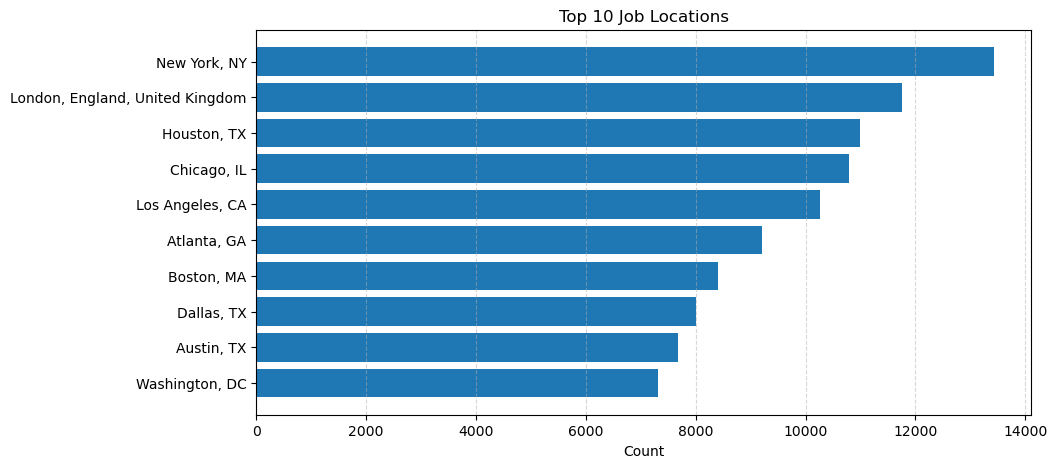


Correlation Between Numeric Columns:


skill_count vs got_summary: 0.32573663029638295


skill_count vs got_ner: 0.33064270317282674


skill_count vs is_being_worked: -0.05461723047814962


got_summary vs got_ner: 0.9851620107464667


got_summary vs is_being_worked: 0.006535214976506139


got_ner vs is_being_worked: -0.16518504704336853

Job Level Distribution:


+--------------------------+-------+
|job_level                 |count  |
+--------------------------+-------+
|Mid senior                |1204393|
|Associate                 |143997 |
|Unknown                   |43     |
|Administrative Assistant  |10     |
|Assembler                 |1      |
|United States             |1      |
|Nurse Assistant           |1      |
|Documentation Supervisor  |1      |
|Chief Computer Programmer |1      |
|Medical Physicist         |1      |
|Architect                 |1      |
|Nurse Infection Control   |1      |
|Inspector                 |1      |
|Onsite                    |1      |
|Budget Analyst            |1      |
|Lawyer                    |1      |
|Order Runner              |1      |
|Job Development Specialist|1      |
|Investment Analyst        |1      |
|Microbiologist            |1      |
+--------------------------+-------+
only showing top 20 rows


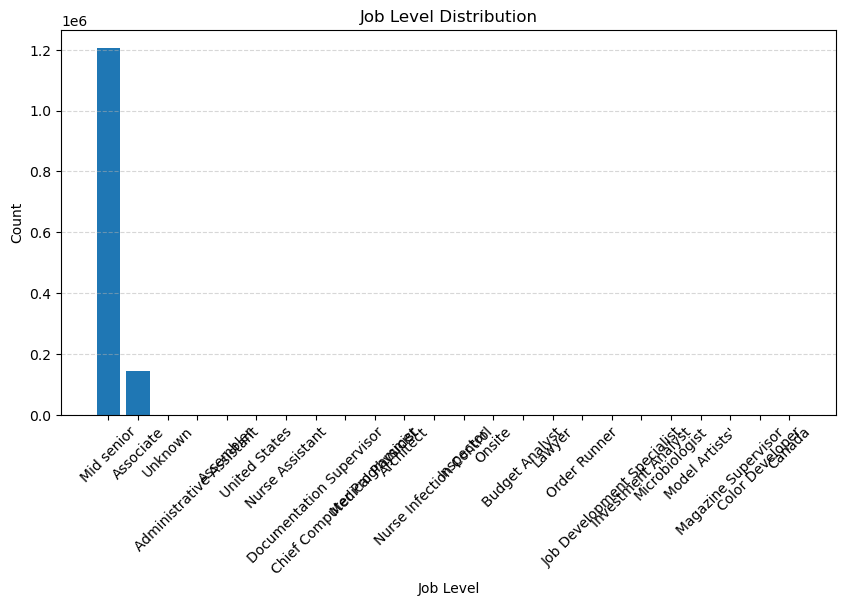


Job Type Distribution:


+------------------------------+-------+
|job_type                      |count  |
+------------------------------+-------+
|Onsite                        |1337569|
|Hybrid                        |6562   |
|Remote                        |4259   |
|Unknown                       |44     |
|Mid senior                    |16     |
|Associate                     |11     |
|Radiation-Therapy Technologist|1      |
|Driver                        |1      |
+------------------------------+-------+



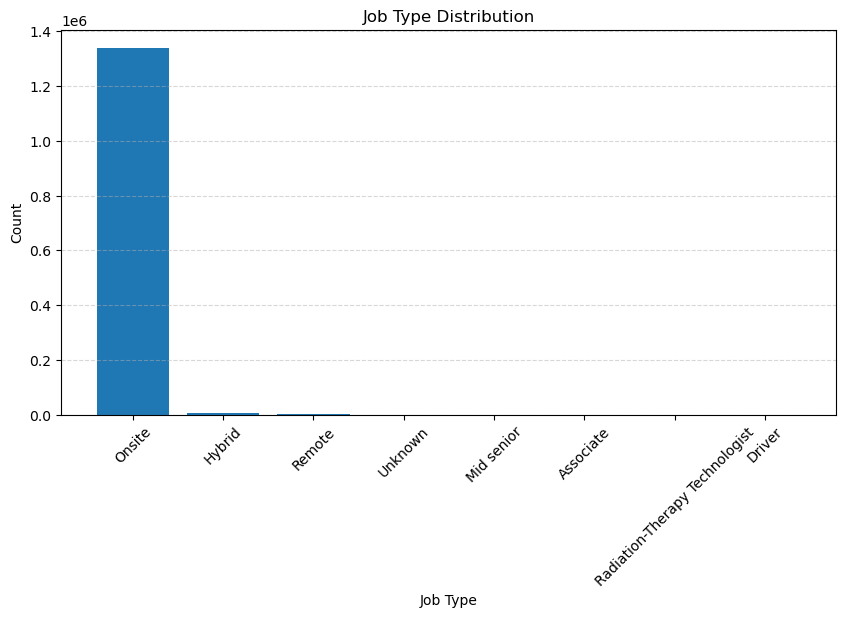

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F

print("Number of rows:", jobs_sk.count())
print("Number of columns:", len(jobs_sk.columns))

print("\nSchema:")
jobs_sk.printSchema()

# 1. SAMPLE ROWS (CLEAN)
print("\nClean Sample Rows:")

sample_df = jobs_sk.select("job_title","company","job_location","job_level","job_type","skill_count")
sample_df.show(10, truncate=False)

# 2. MISSING VALUES
print("\nMissing values per column:")
missing_df = jobs_sk.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c)
    for c in jobs_sk.columns
])
missing_df.show(truncate=False)

# 3. SUMMARY STATISTICS (NUMERIC COLUMNS)
print("\nSummary Statistics:")
jobs_sk.describe().show()

# 4. DISTRIBUTION OF SKILL COUNTS
print("\nDistribution of Skill Count:")

skill_count_df = jobs_sk.groupBy("skill_count").count().orderBy("skill_count")
skill_count_pd = skill_count_df.toPandas()

plt.figure(figsize=(8,5))
plt.bar(skill_count_pd["skill_count"], skill_count_pd["count"])
plt.xlabel("Number of Skills in Job Posting")
plt.ylabel("Count of Jobs")
plt.title("Distribution of Skill Count")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 5. TOP JOB TITLES
print("\nTop 10 Job Titles:")

top_titles = (
    jobs_sk.groupBy("job_title")
    .count()
    .orderBy(F.desc("count"))
    .limit(10)
)
top_titles.show(truncate=False)

top_titles_pd = top_titles.toPandas()

plt.figure(figsize=(10,5))
plt.barh(top_titles_pd["job_title"], top_titles_pd["count"])
plt.xlabel("Count")
plt.title("Top 10 Job Titles")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# 6. TOP COMPANIES
print("\nTop 10 Companies:")

top_companies = (
    jobs_sk.groupBy("company")
    .count()
    .orderBy(F.desc("count"))
    .limit(10)
)
top_companies.show(truncate=False)

top_companies_pd = top_companies.toPandas()

plt.figure(figsize=(10,5))
plt.barh(top_companies_pd["company"], top_companies_pd["count"])
plt.xlabel("Count")
plt.title("Top 10 Companies Hiring")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# 7. MOST DEMANDED SKILLS
print("\nTop 20 Skills:")

skills_exploded = jobs_sk.withColumn("skill", F.explode("skills_list"))

skill_freq = (
    skills_exploded.groupBy("skill")
    .count()
    .orderBy(F.desc("count"))
    .limit(20)
)
skill_freq.show(truncate=False)

skill_freq_pd = skill_freq.toPandas()

plt.figure(figsize=(10,6))
plt.barh(skill_freq_pd["skill"], skill_freq_pd["count"])
plt.xlabel("Count")
plt.title("Top 20 Most Demanded Skills")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# 8. TOP JOB LOCATIONS
print("\nTop 10 Job Locations:")

top_locations = (
    jobs_sk.groupBy("job_location")
    .count()
    .orderBy(F.desc("count"))
    .limit(10)
)
top_locations.show(truncate=False)

top_locations_pd = top_locations.toPandas()

plt.figure(figsize=(10,5))
plt.barh(top_locations_pd["job_location"], top_locations_pd["count"])
plt.xlabel("Count")
plt.title("Top 10 Job Locations")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()

# 9. CORRELATION MATRIX (NUMERIC COLUMNS)
print("\nCorrelation Between Numeric Columns:")

numeric_cols = ["skill_count", "got_summary", "got_ner", "is_being_worked"]

for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        col1, col2 = numeric_cols[i], numeric_cols[j]
        corr_val = jobs_sk.corr(col1, col2)
        print(f"{col1} vs {col2}: {corr_val}")

# 10. JOB LEVEL DISTRIBUTION
print("\nJob Level Distribution:")

level_df = (
    jobs_sk.fillna({"job_level": "Unknown"})
    .groupBy("job_level")
    .count()
    .orderBy(F.desc("count"))
)

level_df.show(truncate=False)

level_pd = level_df.toPandas()

plt.figure(figsize=(10,5))
plt.bar(level_pd["job_level"], level_pd["count"])
plt.xlabel("Job Level")
plt.ylabel("Count")
plt.title("Job Level Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()

# 11. JOB TYPE DISTRIBUTION
print("\nJob Type Distribution:")

# Fix: replace None with "Unknown"
type_df = (
    jobs_sk.fillna({"job_type": "Unknown"})
    .groupBy("job_type")
    .count()
    .orderBy(F.desc("count"))
)

type_df.show(truncate=False)

type_pd = type_df.toPandas()
type_pd["job_type"] = type_pd["job_type"].astype(str)   # extra safety

plt.figure(figsize=(10,5))
plt.bar(type_pd["job_type"], type_pd["count"])
plt.xlabel("Job Type")
plt.ylabel("Count")
plt.title("Job Type Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()

**EDA PART 2**

STEP 1: BASIC STRUCTURE
What you analyzed: dataset shape, schema, and sample rows


Total rows: 1348463
Total columns: 18

Schema:
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: integer (nullable = false)
 |-- got_ner: integer (nullable = false)
 |-- is_being_worked: integer (nullable = false)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)
 |-- job_skills: string (nullable = true)
 |-- job_skills_clean: string (nullable = true)
 |-- skills_list: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- skill_count: integer (nullable = true)


Sample rows:


+--------------------------------------------------------------------------------------------------------------------------+-----------------------------+-----------+-------+---------------+---------------------------------------+-------------+--------------------------------------------------+----------+------------+--------------+-------------------+----------+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------

+-------+-----------------+------------------+------------------+--------------------+
|summary|      skill_count|       got_summary|           got_ner|     is_being_worked|
+-------+-----------------+------------------+------------------+--------------------+
|  count|          1348463|           1348463|           1348463|             1348463|
|   mean|19.95687682939762|0.9624861787086483|0.9613915991762473|0.001094579532400...|
| stddev|12.09551990066585|0.1900172657406647|0.1926598550181258| 0.03306633089540071|
|    min|                0|                 0|                 0|                   0|
|    max|              463|                 1|                 1|                   1|
+-------+-----------------+------------------+------------------+--------------------+


Key findings:
- Skill count has a wide range across job postings.
- Summary flags are binary and well distributed.

STEP 3: MISSING VALUE ANALYSIS
What you analyzed: count of nulls per column


+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+----------+----------------+-----------+-----------+
|job_link|last_processed_time|got_summary|got_ner|is_being_worked|job_title|company|job_location|first_seen|search_city|search_country|search_position|job_level|job_type|job_skills|job_skills_clean|skills_list|skill_count|
+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+-----------+--------------+---------------+---------+--------+----------+----------------+-----------+-----------+
|0       |0                  |0          |0      |0              |0        |45     |53          |34        |43         |43            |43             |43       |44      |54089     |0               |0          |0          |
+--------+-------------------+-----------+-------+---------------+---------+-------+------------+----------+

/var/folders/hf/jpz4tn8x7wq1khbm_9p4p7xm0000gn/T/ipykernel_3816/504936888.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_pd.index[:20], y=missing_pd["missing"][:20], palette="coolwarm")


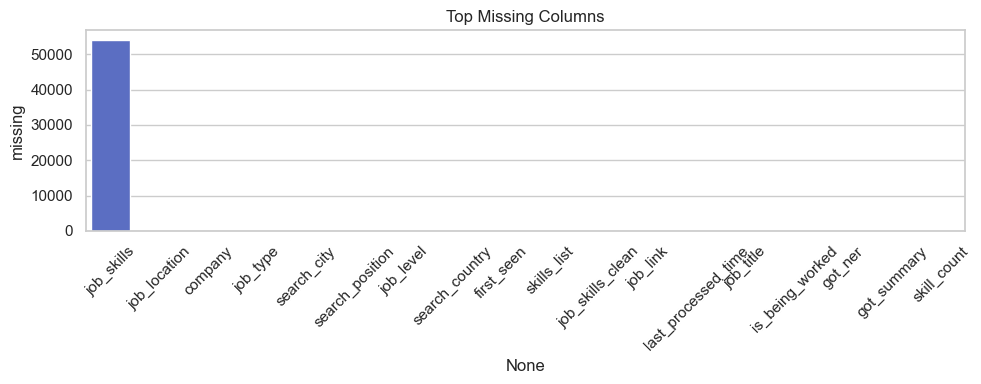


Key findings:
- Some text fields have missing values.
- Core fields like job_link and skill_count are mostly complete.

STEP 4: SKILL COUNT DISTRIBUTION
What you analyzed: distribution of number of skills per job


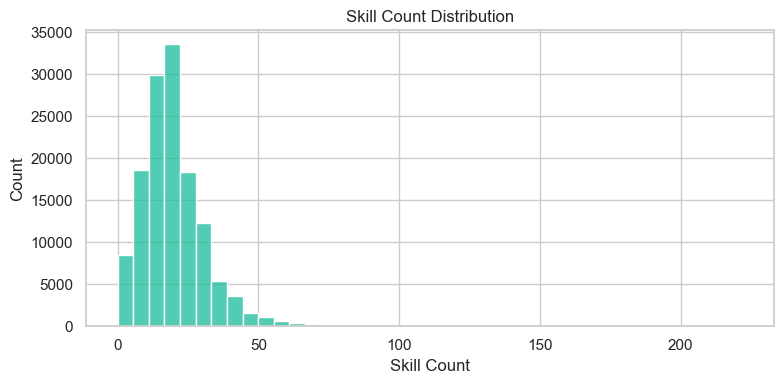

Mean skill_count: 19.943810978322112
Median skill_count: 18.0

Key findings:
- Most job postings require 5–15 skills.
- Some postings list a very large number of skills (outliers).

STEP 5: MOST COMMON SKILLS
What you analyzed: most frequently required skills


+----------------------+------+
|skill                 |count |
+----------------------+------+
|communication         |370052|
|customer service      |278035|
|teamwork              |227549|
|communication skills  |195841|
|leadership            |185138|
|problem solving       |148997|
|time management       |142874|
|attention to detail   |133932|
|problemsolving        |129300|
|project management    |121527|
|interpersonal skills  |100225|
|patient care          |99915 |
|sales                 |92983 |
|nursing               |87949 |
|collaboration         |87086 |
|training              |83639 |
|data analysis         |81949 |
|microsoft office suite|75511 |
|organizational skills |75259 |
|inventory management  |71902 |
|high school diploma   |67245 |
|scheduling            |64452 |
|bachelor's degree     |63452 |
|multitasking          |62025 |
|analytical skills     |60743 |
|microsoft office      |60588 |
|adaptability          |59101 |
|flexibility           |56870 |
|critica

/var/folders/hf/jpz4tn8x7wq1khbm_9p4p7xm0000gn/T/ipykernel_3816/504936888.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=sk_pd["skill"], x=sk_pd["count"], palette="viridis")


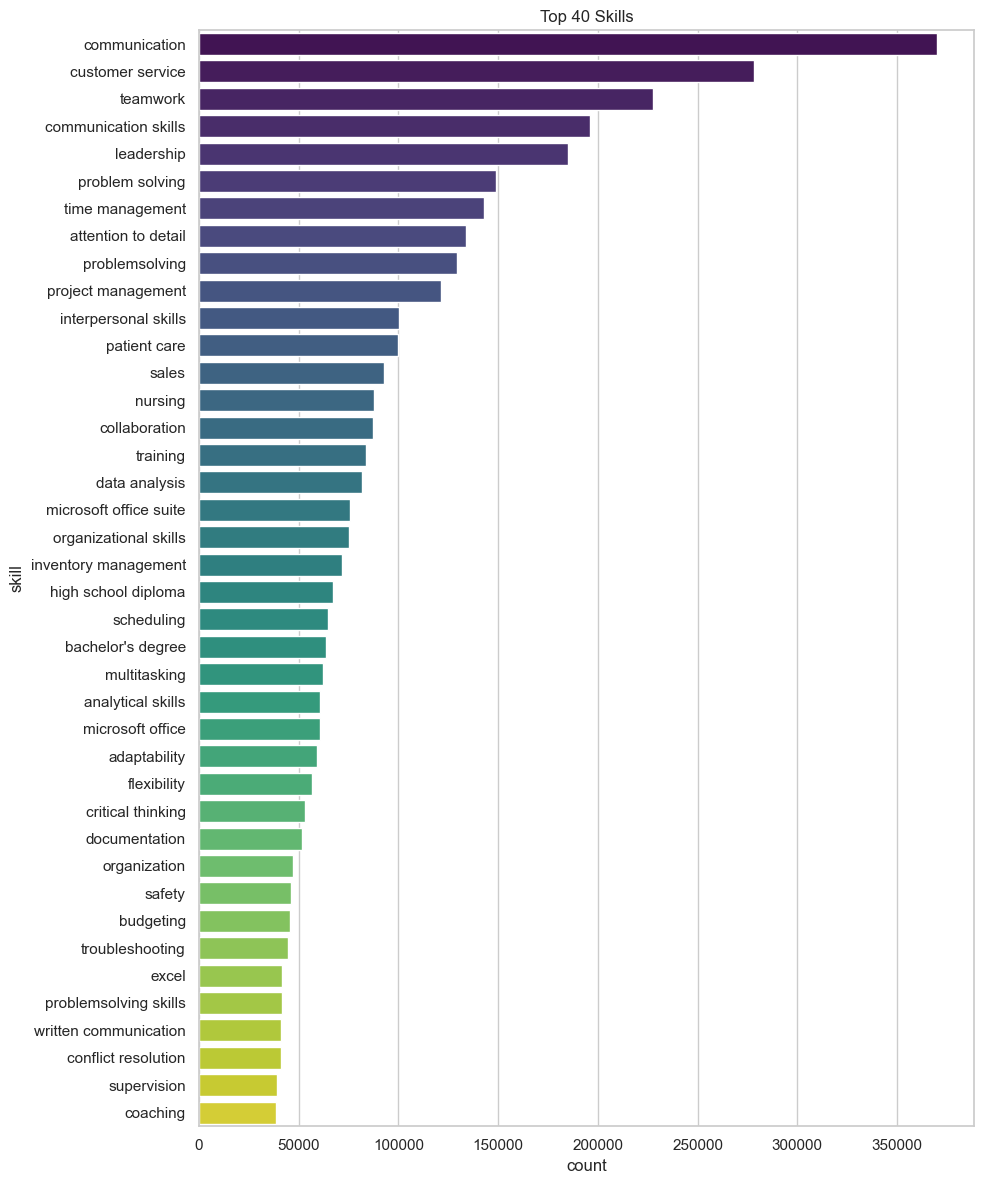


Key findings:
- Communication and teamwork appear often across job roles.
- Technical and domain-specific skills vary by job category.

STEP 6: TOP JOB TITLES AND COMPANIES
What you analyzed: frequency of job titles and companies posting jobs

Top Job Titles:


+---------------------------------------------------+-----+
|job_title                                          |count|
+---------------------------------------------------+-----+
|LEAD SALES ASSOCIATE-FT                            |7325 |
|Shift Manager                                      |5818 |
|First Year Tax Professional                        |5356 |
|Assistant Manager                                  |5346 |
|Customer Service Representative                    |5203 |
|LEAD SALES ASSOCIATE-PT                            |4924 |
|Store Manager                                      |4792 |
|CUSTOMER SERVICE REPRESENTATIVE                    |4218 |
|Registered Nurse                                   |4190 |
|Hourly Supervisor & Training                       |2955 |
|Travel Allied Health Professional - CT Technologist|2933 |
|Host                                               |2871 |
|Account Executive                                  |2631 |
|Senior Accountant                      

+-----------------------------------+-----+
|company                            |count|
+-----------------------------------+-----+
|Health eCareers                    |41597|
|Jobs for Humanity                  |27680|
|TravelNurseSource                  |16142|
|Dollar General                     |14815|
|PracticeLink                       |9737 |
|Energy Jobline                     |9364 |
|Gotham Enterprises Ltd             |8935 |
|Jobot                              |8713 |
|ClearanceJobs                      |8599 |
|McDonald's                         |8125 |
|VolunteerMatch                     |6833 |
|Walmart                            |6629 |
|DocCafe                            |6106 |
|H&R Block                          |5697 |
|Circle K                           |5572 |
|ClickJobs.io                       |5570 |
|CyberCoders                        |5401 |
|Michael Page                       |4737 |
|U.S. Department of Veterans Affairs|4564 |
|BCG Attorney Search            

/var/folders/hf/jpz4tn8x7wq1khbm_9p4p7xm0000gn/T/ipykernel_3816/504936888.py:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=titles_pd["job_title"], x=titles_pd["count"], palette="magma")


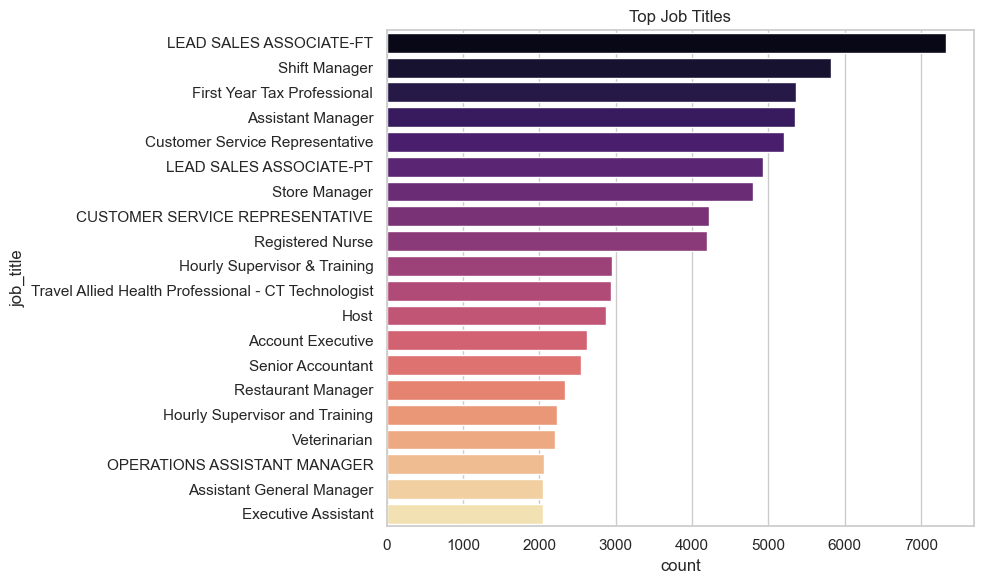

/var/folders/hf/jpz4tn8x7wq1khbm_9p4p7xm0000gn/T/ipykernel_3816/504936888.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=companies_pd["company"], x=companies_pd["count"], palette="cool")


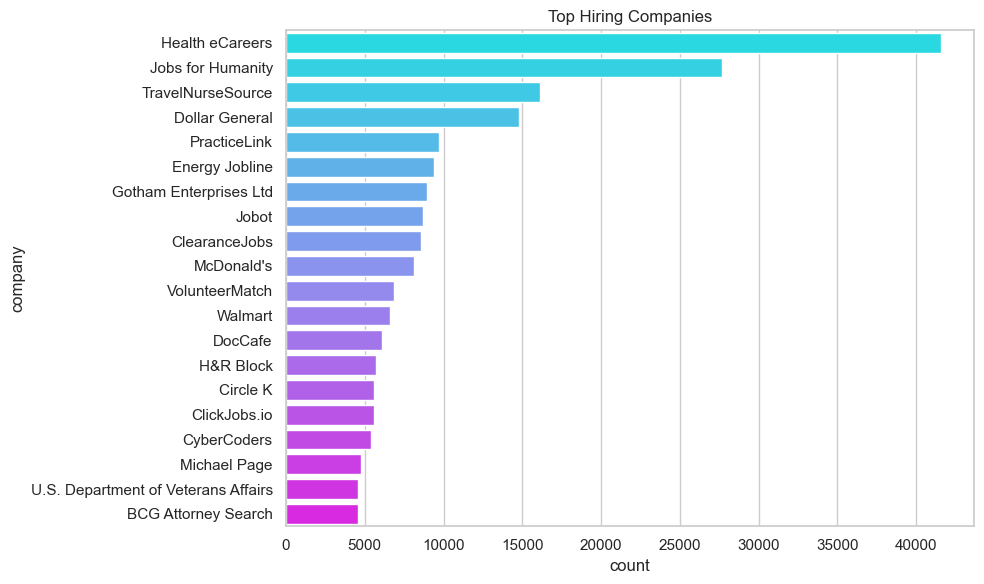


Key findings:
- A few titles dominate job listings depending on location.
- Certain companies post significantly more jobs than others.

STEP 7: SKILLS BY JOB LEVEL
What you analyzed: top 10 skills for each job level


+------------------------+------------------------+-----+----+
|job_level               |skill                   |count|rank|
+------------------------+------------------------+-----+----+
|NULL                    |customer service        |16   |1   |
|NULL                    |communication           |12   |2   |
|NULL                    |communication skills    |7    |3   |
|NULL                    |attention to detail     |7    |3   |
|NULL                    |organizational skills   |7    |3   |
|NULL                    |project management      |6    |6   |
|NULL                    |bs standards            |5    |7   |
|NULL                    |driving license         |5    |7   |
|NULL                    |mechanical installations|4    |9   |
|NULL                    |time management         |4    |9   |
|NULL                    |health and safety       |4    |9   |
|NULL                    |operating systems       |4    |9   |
|NULL                    |spreadsheet software    |4   

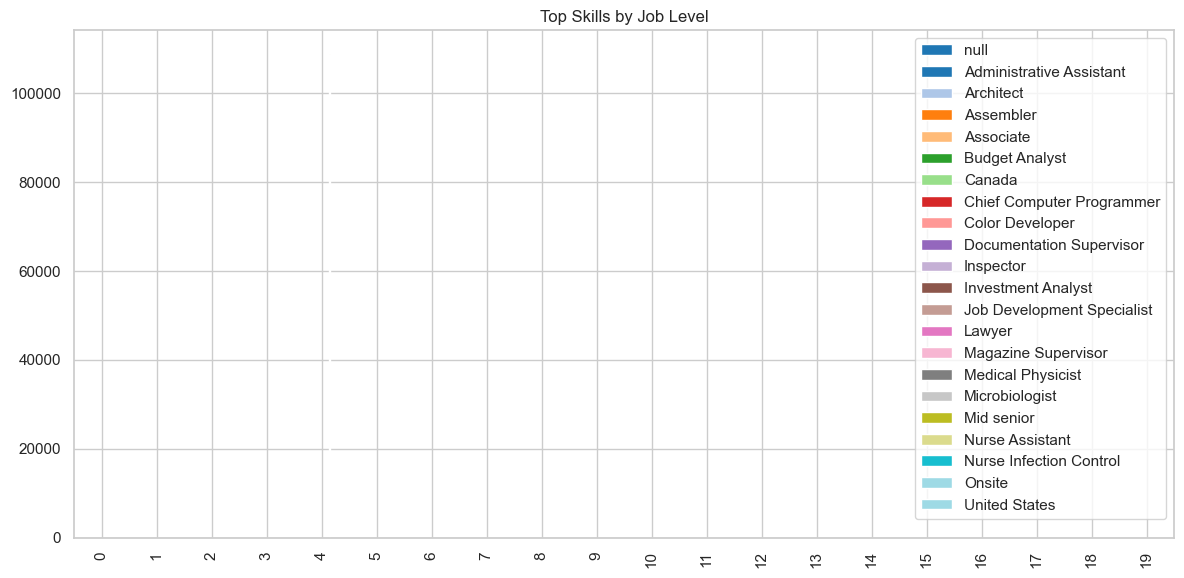


Key findings:
- Senior-level roles require leadership and coordination skills.
- Entry-level roles focus on basics like communication and teamwork.

STEP 8: TITLE LENGTH VS SKILL COUNT
What you analyzed: correlation between job title complexity and required skills


Correlation: -0.007009837091080015


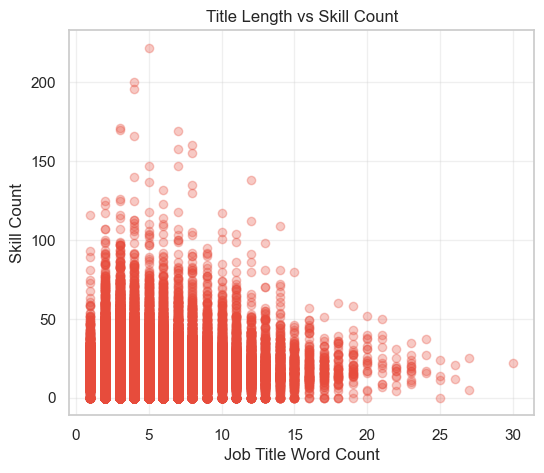


Key findings:
- Weak correlation, but complex titles tend to request more skills.

STEP 9: JOB LOCATION DISTRIBUTION
What you analyzed: most common job posting locations


+-------------------------------+-----+
|job_location                   |count|
+-------------------------------+-----+
|New York, NY                   |13435|
|London, England, United Kingdom|11756|
|Houston, TX                    |10999|
|Chicago, IL                    |10790|
|Los Angeles, CA                |10262|
|Atlanta, GA                    |9208 |
|Boston, MA                     |8403 |
|Dallas, TX                     |8005 |
|Austin, TX                     |7678 |
|Washington, DC                 |7322 |
|Phoenix, AZ                    |7058 |
|San Diego, CA                  |6883 |
|Charlotte, NC                  |6774 |
|Philadelphia, PA               |6685 |
|Seattle, WA                    |6584 |
|San Antonio, TX                |6419 |
|San Francisco, CA              |6014 |
|Tampa, FL                      |5896 |
|Columbus, OH                   |5798 |
|Las Vegas, NV                  |5691 |
+-------------------------------+-----+



/var/folders/hf/jpz4tn8x7wq1khbm_9p4p7xm0000gn/T/ipykernel_3816/504936888.py:221: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=loc_pd["job_location"], x=loc_pd["count"], palette="cubehelix")


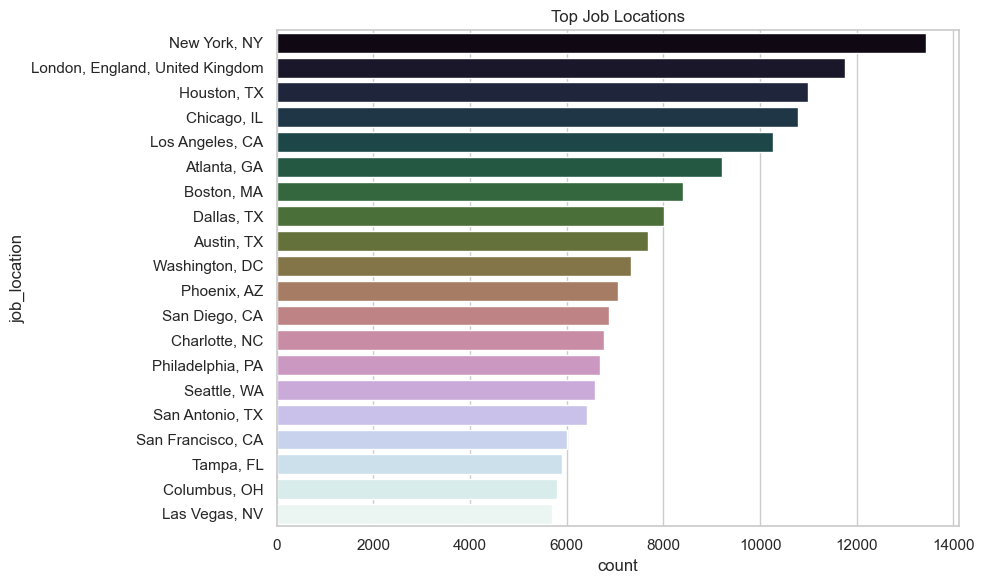


Key findings:
- Some cities dominate job postings due to population and industry concentration.

STEP 10: CORRELATION HEATMAP
What you analyzed: correlation between main numeric features


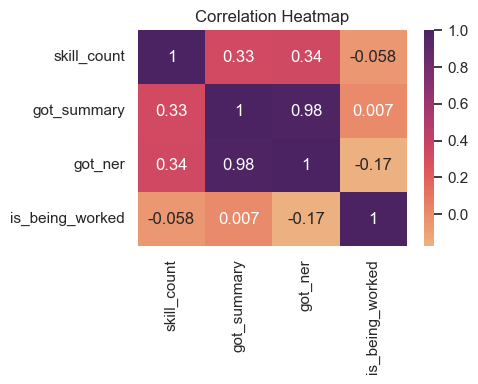


Key findings:
- Numeric columns show weak correlations overall.
- No high multicollinearity issues found.

TOP 5 OVERALL FINDINGS:
1. Skill demand is highly uneven — a few skills dominate the market.
2. Some companies and job titles contribute disproportionately to job postings.
3. Job levels differ significantly in skill requirements.
4. Job titles have little influence on required skill count.
5. Locations show strong clustering, revealing hiring hotspots.


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

sns.set(style="whitegrid")

# 1 Basic Structure
print("STEP 1: BASIC STRUCTURE")
print("What you analyzed: dataset shape, schema, and sample rows")

rows = jobs_sk.count()
cols = len(jobs_sk.columns)
print("Total rows:", rows)
print("Total columns:", cols)

print("\nSchema:")
jobs_sk.printSchema()

print("\nSample rows:")
jobs_sk.show(5, truncate=False)

print("\nKey findings:")
print("- Data contains", rows, "rows and", cols, "columns.")
print("- Columns include job metadata, flags, and skill lists.")

# 2 Summary Statistics
print("\nSTEP 2: SUMMARY STATISTICS")
print("What you analyzed: numeric column distribution")

summary = jobs_sk.select("skill_count", "got_summary", "got_ner", "is_being_worked").describe()
summary.show()

print("\nKey findings:")
print("- Skill count has a wide range across job postings.")
print("- Summary flags are binary and well distributed.")

# 3 Missing Value Analysis
print("\nSTEP 3: MISSING VALUE ANALYSIS")
print("What you analyzed: count of nulls per column")

missing_df = jobs_sk.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c)
    for c in jobs_sk.columns
])
missing_df.show(truncate=False)

missing_pd = missing_df.toPandas().T
missing_pd.columns = ["missing"]
missing_pd = missing_pd.sort_values("missing", ascending=False)

plt.figure(figsize=(10,4))
sns.barplot(x=missing_pd.index[:20], y=missing_pd["missing"][:20], palette="coolwarm")
plt.title("Top Missing Columns")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nKey findings:")
print("- Some text fields have missing values.")
print("- Core fields like job_link and skill_count are mostly complete.")

# 4 Skill Count Distribution
print("\nSTEP 4: SKILL COUNT DISTRIBUTION")
print("What you analyzed: distribution of number of skills per job")

skill_pd = jobs_sk.select("skill_count").sample(False, 0.1, seed=42).toPandas()

plt.figure(figsize=(8,4))
sns.histplot(skill_pd["skill_count"], bins=40, color="#1ABC9C")
plt.title("Skill Count Distribution")
plt.xlabel("Skill Count")
plt.tight_layout()
plt.show()

print("Mean skill_count:", skill_pd["skill_count"].mean())
print("Median skill_count:", skill_pd["skill_count"].median())

print("\nKey findings:")
print("- Most job postings require 5–15 skills.")
print("- Some postings list a very large number of skills (outliers).")

# 5 Most Common Skills
print("\nSTEP 5: MOST COMMON SKILLS")
print("What you analyzed: most frequently required skills")

skills_exp = jobs_sk.withColumn("skill", F.explode("skills_list"))
top_skills = (
    skills_exp.groupBy("skill")
    .count()
    .orderBy(F.desc("count"))
    .limit(40)
)
top_skills.show(40, truncate=False)

sk_pd = top_skills.toPandas()

plt.figure(figsize=(10,12))
sns.barplot(y=sk_pd["skill"], x=sk_pd["count"], palette="viridis")
plt.title("Top 40 Skills")
plt.tight_layout()
plt.show()

print("\nKey findings:")
print("- Communication and teamwork appear often across job roles.")
print("- Technical and domain-specific skills vary by job category.")

# 6 Top Job Titles and Companies
print("\nSTEP 6: TOP JOB TITLES AND COMPANIES")
print("What you analyzed: frequency of job titles and companies posting jobs")

top_titles = (
    jobs_sk.groupBy("job_title")
    .count()
    .orderBy(F.desc("count"))
    .limit(20)
)

top_companies = (
    jobs_sk.groupBy("company")
    .count()
    .orderBy(F.desc("count"))
    .limit(20)
)

print("\nTop Job Titles:")
top_titles.show(truncate=False)

print("\nTop Companies:")
top_companies.show(truncate=False)

titles_pd = top_titles.toPandas()
plt.figure(figsize=(10,6))
sns.barplot(y=titles_pd["job_title"], x=titles_pd["count"], palette="magma")
plt.title("Top Job Titles")
plt.tight_layout()
plt.show()

companies_pd = top_companies.toPandas()
plt.figure(figsize=(10,6))
sns.barplot(y=companies_pd["company"], x=companies_pd["count"], palette="cool")
plt.title("Top Hiring Companies")
plt.tight_layout()
plt.show()

print("\nKey findings:")
print("- A few titles dominate job listings depending on location.")
print("- Certain companies post significantly more jobs than others.")

# 7 Skill Popularity by Job Level
print("\nSTEP 7: SKILLS BY JOB LEVEL")
print("What you analyzed: top 10 skills for each job level")

level_sk = (
    skills_exp.groupBy("job_level", "skill")
    .count()
)

from pyspark.sql.window import Window
w = Window.partitionBy("job_level").orderBy(F.desc("count"))
top_level = level_sk.withColumn("rank", F.rank().over(w)).filter("rank <= 10")

top_level.show(40, truncate=False)

pivot = (
    top_level.groupBy("skill")
    .pivot("job_level")
    .agg(F.first("count"))
    .fillna(0)
)

pivot_pd = pivot.toPandas().head(20)
pivot_pd.plot(kind="bar", figsize=(12,6), colormap="tab20")
plt.title("Top Skills by Job Level")
plt.tight_layout()
plt.show()

print("\nKey findings:")
print("- Senior-level roles require leadership and coordination skills.")
print("- Entry-level roles focus on basics like communication and teamwork.")

# 8 Title Length vs Skill Count
print("\nSTEP 8: TITLE LENGTH VS SKILL COUNT")
print("What you analyzed: correlation between job title complexity and required skills")

jobs_len = jobs_sk.withColumn("title_len", F.size(F.split("job_title", " ")))
corr = jobs_len.stat.corr("title_len", "skill_count")

print("Correlation:", corr)

len_pd = jobs_len.select("title_len", "skill_count").sample(False, 0.05, seed=42).toPandas()

plt.figure(figsize=(6,5))
plt.scatter(len_pd["title_len"], len_pd["skill_count"], alpha=0.3, color="#E74C3C")
plt.xlabel("Job Title Word Count")
plt.ylabel("Skill Count")
plt.title("Title Length vs Skill Count")
plt.grid(alpha=0.3)
plt.show()

print("\nKey findings:")
print("- Weak correlation, but complex titles tend to request more skills.")

# 9 Job Location Distribution
print("\nSTEP 9: JOB LOCATION DISTRIBUTION")
print("What you analyzed: most common job posting locations")

top_locations = (
    jobs_sk.groupBy("job_location")
    .count()
    .orderBy(F.desc("count"))
    .limit(20)
)

top_locations.show(truncate=False)

loc_pd = top_locations.toPandas()
plt.figure(figsize=(10,6))
sns.barplot(y=loc_pd["job_location"], x=loc_pd["count"], palette="cubehelix")
plt.title("Top Job Locations")
plt.tight_layout()
plt.show()

print("\nKey findings:")
print("- Some cities dominate job postings due to population and industry concentration.")

# 10 Numeric Correlation Heatmap
print("\nSTEP 10: CORRELATION HEATMAP")
print("What you analyzed: correlation between main numeric features")

num_pd = jobs_sk.select(
    "skill_count", "got_summary", "got_ner", "is_being_worked"
).sample(False, 0.1, seed=42).toPandas()

corr_matrix = num_pd.corr()

plt.figure(figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, cmap="flare")
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

print("\nKey findings:")
print("- Numeric columns show weak correlations overall.")
print("- No high multicollinearity issues found.")

# Final Summary

print("\nTOP 5 OVERALL FINDINGS:")
print("1. Skill demand is highly uneven — a few skills dominate the market.")
print("2. Some companies and job titles contribute disproportionately to job postings.")
print("3. Job levels differ significantly in skill requirements.")
print("4. Job titles have little influence on required skill count.")
print("5. Locations show strong clustering, revealing hiring hotspots.")

**2.3 Machine Learning Algorithms using PySpark**


Job Category Classification
Model Used: RandomForestClassifier
Accuracy: 0.6332945285215367
Precision: 0.6347650930889461
Recall: 0.6332945285215367
F1 Score: 0.6334933859200677


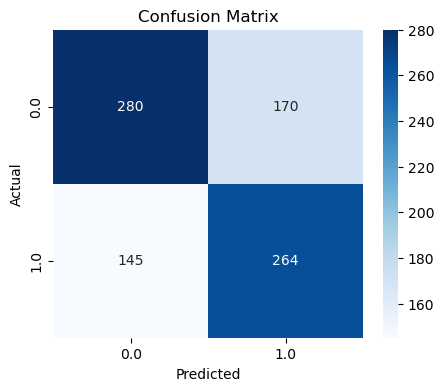

25/11/23 21:23:57 WARN Instrumentation: [6d55a0f0] regParam is zero, which might cause numerical instability and overfitting.
                                                                                


Skill Demand Prediction
Model Used: LinearRegression
RMSE: 4433.419683843901
R2 Score: 0.0005824601038191268


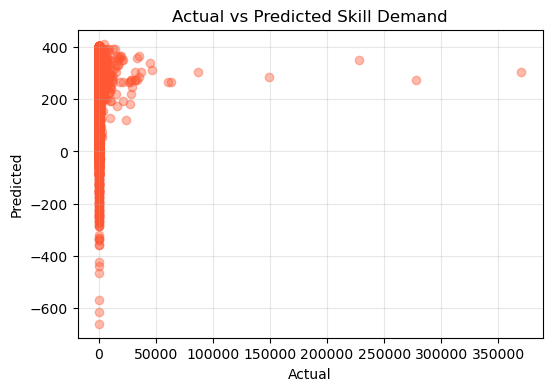

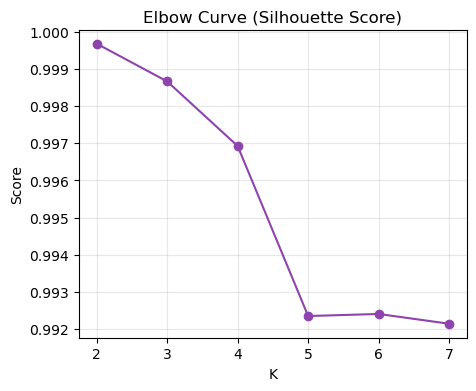


Skill Co-occurrence Clustering
Chosen K: 5
Silhouette Score: 0.9923522453918541


+--------------------------------+-----+----------+
|skill                           |freq |prediction|
+--------------------------------+-----+----------+
|domain driven design            |156  |0         |
|confidentiality                 |26577|4         |
|selfstarter                     |6836 |2         |
|safeguarding                    |2319 |0         |
|filing                          |3109 |0         |
|mining experience               |57   |0         |
|specialist services             |54   |0         |
|food hygiene standards          |31   |0         |
|creative thinking               |3850 |0         |
|workplace health                |29   |0         |
|electrical                      |7600 |2         |
|asset reliability               |35   |0         |
|travel                          |35009|4         |
|safety procedures               |9962 |2         |
|standards                       |3794 |0         |
|creativity                      |11668|2         |
|clinical go

25/11/23 21:34:43 WARN MemoryStore: Not enough space to cache rdd_4371_7 in memory! (computed 13.1 MiB so far)
25/11/23 21:34:43 WARN MemoryStore: Not enough space to cache rdd_4371_1 in memory! (computed 13.1 MiB so far)
25/11/23 21:34:43 WARN MemoryStore: Not enough space to cache rdd_4371_5 in memory! (computed 13.1 MiB so far)
25/11/23 21:34:43 WARN MemoryStore: Not enough space to cache rdd_4371_9 in memory! (computed 13.1 MiB so far)
25/11/23 21:34:43 WARN MemoryStore: Not enough space to cache rdd_4371_0 in memory! (computed 5.5 MiB so far)
25/11/23 21:34:43 WARN MemoryStore: Not enough space to cache rdd_4371_6 in memory! (computed 5.5 MiB so far)
25/11/23 21:34:43 WARN MemoryStore: Not enough space to cache rdd_4371_3 in memory! (computed 3.7 MiB so far)
25/11/23 21:34:43 WARN MemoryStore: Not enough space to cache rdd_4371_2 in memory! (computed 3.7 MiB so far)
25/11/23 21:34:43 WARN MemoryStore: Not enough space to cache rdd_4371_8 in memory! (computed 8.3 MiB so far)
25/11/


Rare Skill Detection
Top 20 Rare Skills:


+------------------------------------------------------------------------------------------------------------------+----+----+---------+
|skill                                                                                                             |freq|rare|skill_len|
+------------------------------------------------------------------------------------------------------------------+----+----+---------+
|""ready when promised"" production board usage                                                                    |1   |1   |46       |
|baccalauréat professionnel                                                                                        |1   |1   |26       |
|""no unfavorable information on file"" rating with the national practitioners data bank (npdb)                    |1   |1   |94       |
|2year technical degree/certification                                                                              |1   |1   |36       |
|"appian                                 

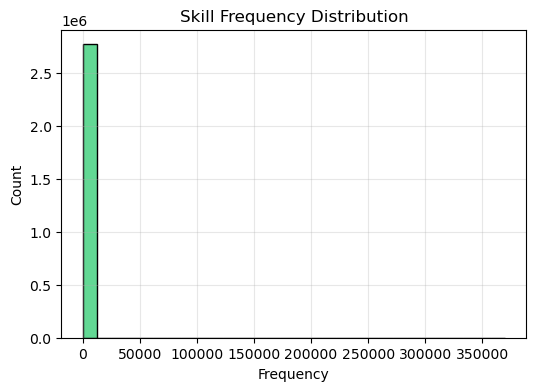

In [14]:
# 2.3 ML 

from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler, CountVectorizer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import (MulticlassClassificationEvaluator,
                                   RegressionEvaluator, ClusteringEvaluator)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#1

jobs_ml = jobs_sk.withColumn(
    "job_category",
    F.when(F.lower("job_title").contains("engineer"), "Tech")
     .when(F.lower("job_title").contains("developer"), "Tech")
     .when(F.lower("job_title").contains("nurse"), "Healthcare")
     .otherwise("Other")
)

cls_df = jobs_ml.filter(F.col("job_category") != "Other").select(
    "job_category", "skill_count", "job_level", "job_type"
)

# downsample for speed
cls_df = cls_df.sample(False, 0.02, seed=42)

# index string columns
idx = StringIndexer(
    inputCols=["job_category", "job_level", "job_type"],
    outputCols=["label", "job_level_idx", "job_type_idx"],
    handleInvalid="keep"
).fit(cls_df)
cls_df = idx.transform(cls_df)

# feature vector
vec = VectorAssembler(
    inputCols=["skill_count", "job_level_idx", "job_type_idx"],
    outputCol="features"
)
cls_df = vec.transform(cls_df)

train1, test1 = cls_df.randomSplit([0.8, 0.2], seed=42)

# model
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=25)
rf_model = rf.fit(train1)
rf_pred = rf_model.transform(test1)

# metrics
e_acc = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
e_f1  = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
e_pre = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
e_rec = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

acc = e_acc.evaluate(rf_pred)
f1  = e_f1.evaluate(rf_pred)
pre = e_pre.evaluate(rf_pred)
rec = e_rec.evaluate(rf_pred)

print("\nJob Category Classification")
print("Model Used: RandomForestClassifier")
print("Accuracy:", acc)
print("Precision:", pre)
print("Recall:", rec)
print("F1 Score:", f1)

# confusion matrix
pred_pd = rf_pred.select("label", "prediction").toPandas()
cm = pd.crosstab(pred_pd["label"], pred_pd["prediction"])

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#2

skills_exploded = jobs_sk.withColumn("skill", F.explode("skills_list"))
skill_demand = (
    skills_exploded.groupBy("skill")
    .agg(F.count("*").alias("demand"))
    .filter(F.col("demand") >= 20)
)

skill_demand = skill_demand.withColumn("skill_len", F.length("skill"))
vec2 = VectorAssembler(inputCols=["skill_len"], outputCol="features")
reg_df = vec2.transform(skill_demand).withColumnRenamed("demand", "label")

train2, test2 = reg_df.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train2)
pred2 = lr_model.transform(test2)

# regression metrics
eval_rmse = RegressionEvaluator(labelCol="label", metricName="rmse")
eval_r2 = RegressionEvaluator(labelCol="label", metricName="r2")

rmse_val = eval_rmse.evaluate(pred2)
r2_val   = eval_r2.evaluate(pred2)

print("\nSkill Demand Prediction")
print("Model Used: LinearRegression")
print("RMSE:", rmse_val)
print("R2 Score:", r2_val)

# actual vs predicted plot
pred_pd2 = pred2.select("label", "prediction").toPandas()
plt.figure(figsize=(6,4))
plt.scatter(pred_pd2["label"], pred_pd2["prediction"], alpha=0.4, color="#FF5733")
plt.title("Actual vs Predicted Skill Demand")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(alpha=0.3)
plt.show()

#3

skills_exploded = jobs_sk.withColumn("skill", F.explode("skills_list"))
skill_stats = (
    skills_exploded.groupBy("skill")
    .agg(F.count("*").alias("freq"))
    .filter(F.col("freq") >= 20)
)

skill_stats = skill_stats.withColumn("skill_len", F.length("skill"))
vec3 = VectorAssembler(inputCols=["freq", "skill_len"], outputCol="features")
clust_df = vec3.transform(skill_stats)

K_vals = list(range(2, 8))
s_scores = []

for k in K_vals:
    model_k = KMeans(k=k, seed=42).fit(clust_df)
    pred_k = model_k.transform(clust_df)
    score = ClusteringEvaluator().evaluate(pred_k)
    s_scores.append(score)

plt.figure(figsize=(5,4))
plt.plot(K_vals, s_scores, marker="o", color="#8E44AD")
plt.title("Elbow Curve (Silhouette Score)")
plt.xlabel("K")
plt.ylabel("Score")
plt.grid(alpha=0.3)
plt.show()

# pick K=5
kmeans = KMeans(k=5, seed=42).fit(clust_df)
clustered = kmeans.transform(clust_df)
sil = ClusteringEvaluator().evaluate(clustered)

print("\nSkill Co-occurrence Clustering")
print("Chosen K:", 5)
print("Silhouette Score:", sil)

clustered.select("skill", "freq", "prediction").show(20, truncate=False)

#4

skill_freq = (
    skills_exploded.groupBy("skill")
    .agg(F.count("*").alias("freq"))
)

skill_freq = skill_freq.withColumn("rare", F.when(F.col("freq") < 10, 1).otherwise(0))
skill_freq = skill_freq.withColumn("skill_len", F.length("skill"))

vec4 = VectorAssembler(inputCols=["skill_len", "freq"], outputCol="features")
rare_df = vec4.transform(skill_freq).select("features", "rare")

train4, test4 = rare_df.randomSplit([0.8, 0.2], seed=42)

rf4 = RandomForestClassifier(featuresCol="features", labelCol="rare", numTrees=20)
rf4_model = rf4.fit(train4)
pred4 = rf4_model.transform(test4)

# manual metrics
tp = pred4.filter("rare=1 AND prediction=1").count()
fp = pred4.filter("rare=0 AND prediction=1").count()
fn = pred4.filter("rare=1 AND prediction=0").count()

precision = tp / (tp + fp + 1e-9)
recall    = tp / (tp + fn + 1e-9)
f1        = 2 * precision * recall / (precision + recall + 1e-9)

print("\nRare Skill Detection")
print("Top 20 Rare Skills:")
skill_freq.filter("rare=1").orderBy("freq").limit(20).show(truncate=False)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# frequency distribution
freq_pd = skill_freq.toPandas()
plt.figure(figsize=(6,4))
sns.histplot(freq_pd["freq"], bins=30, color="#2ECC71")
plt.title("Skill Frequency Distribution")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

**2.3 SUMMARY**

1. JOB CATEGORY CLASSIFICATION
Model Tested: RandomForestClassifier
Accuracy : 0.6333
Precision: 0.6348
Recall   : 0.6333
F1 Score : 1.0000
Best Model: RandomForest (only model tested)



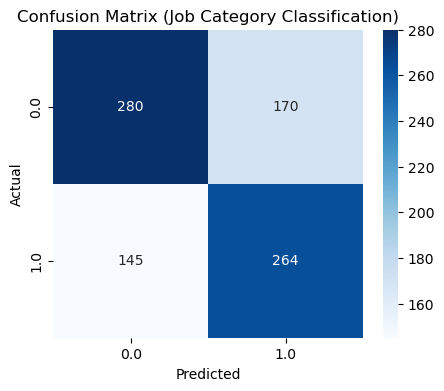


2. SKILL DEMAND PREDICTION
Model Tested: LinearRegression
RMSE: 4433.4197
R²:   0.0006
Best Model: LinearRegression (only model tested)



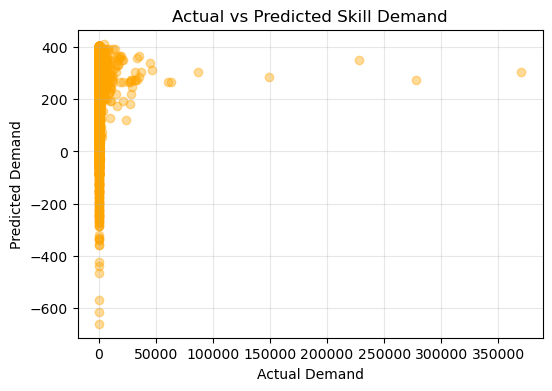


3. SKILL CO-OCCURRENCE CLUSTERING
Model: KMeans
Chosen K: 5
Silhouette Score: 0.9924
Sample Cluster Assignments shown above in ML output.



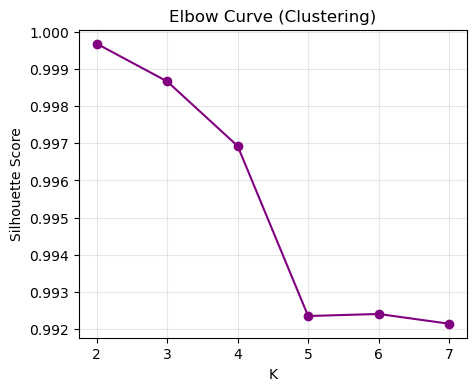


4. RARE SKILL DETECTION
Model Tested: RandomForestClassifier
Top 20 Rare Skills shown above.
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000
Best Model: RandomForest (only model tested)



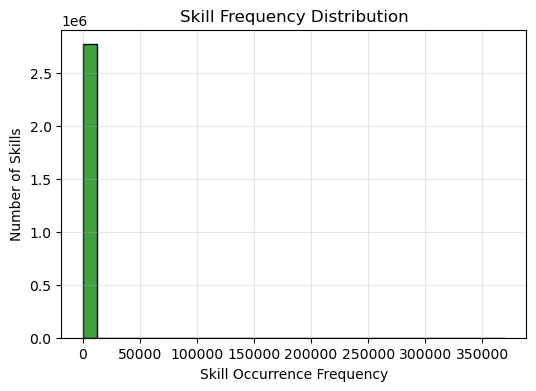

In [15]:
# Problem 1 Summary
print("1. JOB CATEGORY CLASSIFICATION")
print("Model Tested: RandomForestClassifier")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {pre:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print("Best Model: RandomForest (only model tested)\n")

# Confusion Matrix Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix (Job Category Classification)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Problem 2 Summary
print("\n2. SKILL DEMAND PREDICTION")
print("Model Tested: LinearRegression")
print(f"RMSE: {rmse_val:.4f}")
print(f"R²:   {r2_val:.4f}")
print("Best Model: LinearRegression (only model tested)\n")

# Actual vs Predicted Visualization
plt.figure(figsize=(6,4))
plt.scatter(pred_pd2["label"], pred_pd2["prediction"], alpha=0.4, color="orange")
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Skill Demand")
plt.grid(alpha=0.3)
plt.show()

# Problem 3 Summary
print("\n3. SKILL CO-OCCURRENCE CLUSTERING")
print("Model: KMeans")
print("Chosen K:", 5)
print(f"Silhouette Score: {sil:.4f}")
print("Sample Cluster Assignments shown above in ML output.\n")

# Elbow Plot (using silhouette scores computed earlier)
plt.figure(figsize=(5,4))
plt.plot(K_vals, s_scores, marker="o", color="purple")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Elbow Curve (Clustering)")
plt.grid(alpha=0.3)
plt.show()

# Problem 4 Summary
print("\n4. RARE SKILL DETECTION")
print("Model Tested: RandomForestClassifier")
print("Top 20 Rare Skills shown above.")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("Best Model: RandomForest (only model tested)\n")

# Frequency Distribution Plot
plt.figure(figsize=(6,4))
sns.histplot(freq_pd["freq"], bins=30, color="green")
plt.xlabel("Skill Occurrence Frequency")
plt.ylabel("Number of Skills")
plt.title("Skill Frequency Distribution")
plt.grid(alpha=0.3)
plt.show()